### $\bullet\;Import\;Libraries$

In [1]:
%pip install torchmetrics
%pip install torchview

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn             as nn
import torch.optim          as optim
import torch.nn.functional  as F
import torch.backends.cudnn as cudnn
import torchvision
import matplotlib.pyplot    as plt
import numpy                as np
import pandas               as pd
import os
import pickle

from torch.utils.data       import TensorDataset, DataLoader, random_split
from torchvision            import transforms
from torchvision.datasets   import CIFAR10
from torchmetrics           import Accuracy
from tqdm                   import tqdm
from torch.utils.data       import Dataset
from PIL                    import Image
from math                   import sqrt

from torchview import draw_graph
from IPython.display import Image, display

plt.style.use('grayscale')

### $\bullet\;CIFAR\;Dataset$

#### $Load\;Dataset$

In [3]:
dataset = CIFAR10(root='./cifar10', train=True, download=True, transform=transforms.ToTensor())

loader = DataLoader(dataset, batch_size=len(dataset), shuffle=False, num_workers=2)
data_iter = iter(loader)
images, _ = next(data_iter) 

mean = images.mean(dim=[0, 2, 3])
std = images.std(dim=[0, 2, 3])

print("Mean per channel :", mean)
print("Std per channel  :", std)

Mean per channel : tensor([0.4914, 0.4822, 0.4465])
Std per channel  : tensor([0.2470, 0.2435, 0.2616])


In [4]:
transform   = transforms.Compose([transforms.ToTensor(), transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616])])

train_set   = CIFAR10(root='./cifar10', train=True , download=True, transform=transform)
test_set    = CIFAR10(root='./cifar10', train=False, download=True, transform=transform)


testset = test_set
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=0) # batch_size=1 برای پردازش تکی

In [5]:
# import torch
# import torchvision
# import numpy as np
# from torchvision import transforms
# from torchvision.datasets import CIFAR10

# # --- تنظیمات شما ---
# # این متغیر تعداد عکس‌هایی هست که می‌خواید برای تست استفاده کنید
# # می‌تونید هر عددی تا 10000 (کل تعداد عکس‌های تست CIFAR10) رو اینجا بذارید.
# # برای شروع و دیباگ، 100 یا 1000 عدد خوبیه.
# NUM_TEST_SAMPLES = 1000 # مثلاً فقط 1000 عکس اول رو تست می‌کنیم
# # --- بارگذاری داده‌های تست CIFAR10 ---

# # --- آماده‌سازی DataLoader برای گرفتن داده‌ها ---
# # batch_size=1 یعنی هر بار یه عکس رو می‌گیریم
# # shuffle=False یعنی ترتیب عکس‌ها ثابت و همون ترتیب اصلی باشه
# testloader = torch.utils.data.DataLoader(test_set, batch_size=1, shuffle=False, num_workers=0)

# # --- ذخیره تصاویر و برچسب‌ها در فایل‌های باینری ---
# # نام فایل‌ها رو جوری انتخاب می‌کنیم که معلوم باشه برای تست Subset هستن
# output_image_file = "cifar10_test_images_subset.bin"
# output_label_file = "cifar10_test_labels_subset.bin"

# image_count = 0
# with open(output_image_file, "wb") as img_file, \
#      open(output_label_file, "wb") as label_file:
#     for i, (images, labels) in enumerate(testloader):
#         # تبدیل تنسور PyTorch به آرایه NumPy از نوع float32
#         # .squeeze(0) بعد batch رو حذف می‌کنه چون batch_size=1 هست
#         # .numpy() تبدیل به NumPy
#         # .astype(np.float32) اطمینان از نوع float32
#         image_data = images.squeeze(0).numpy().astype(np.float32)
#         image_data.tofile(img_file) # ذخیره به صورت باینری خام

#         # تبدیل لیبل (برچسب) به NumPy از نوع int32 و ذخیره
#         label_data = np.array(labels.item()).astype(np.int32)
#         label_data.tofile(label_file)

#         image_count += 1
#         if image_count % 100 == 0:
#             print(f"Processed {image_count} images.")

#         # **اینجاست که تعداد عکس‌ها رو کنترل می‌کنیم!**
#         # اگه به تعداد دلخواه رسیدیم، حلقه رو متوقف می‌کنیم.
#         if image_count >= NUM_TEST_SAMPLES:
#             break

# print(f"\nSaved {image_count} test images and labels to '{output_image_file}' and '{output_label_file}'.")
# print(f"Total samples used for C testing: {image_count}")

# # --- ارزیابی مدل پایتون روی همین تعداد داده ---
# # حالا مدل پایتون رو روی همین 'NUM_TEST_SAMPLES' تا عکس ارزیابی می‌کنیم.
# # اول باید مطمئن بشید که 'model' شما تعریف و لود شده.
# # مثلاً: model = YourModelClass()
# # model.load_state_dict(torch.load('your_model_weights.pth')) # اگر وزنه مدل رو از فایل لود می‌کنید
# # model.eval() # مدل رو در حالت ارزیابی قرار بدید

# # --- ایجاد Subset از test_set برای ارزیابی پایتون ---
# # این کار مطمئن میشه که پایتون هم دقیقاً روی همون N تا عکس اول تست می‌کنه
# subset_indices = list(range(NUM_TEST_SAMPLES))
# test_subset = torch.utils.data.Subset(test_set, subset_indices)
# test_set = test_subset

In [6]:
len(train_set)

50000

In [7]:
import torch
import torchvision
import numpy as np


testset = test_set
testloader = torch.utils.data.DataLoader(testset, batch_size=1, shuffle=False, num_workers=0) # batch_size=1 برای پردازش تکی

# ذخیره تصاویر و برچسب‌ها


#### $Train\;set-Test\;set\;Classes$

In [8]:
pd.DataFrame(train_set.class_to_idx.items(), columns=['Class Name', 'Class Index']).style.hide()

Class Name,Class Index
airplane,0
automobile,1
bird,2
cat,3
deer,4
dog,5
frog,6
horse,7
ship,8
truck,9


In [9]:
pd.DataFrame(train_set.class_to_idx.items(), columns=['Class Name', 'Class Index']).style.hide()

Class Name,Class Index
airplane,0
automobile,1
bird,2
cat,3
deer,4
dog,5
frog,6
horse,7
ship,8
truck,9


In [10]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val    = 0
        self.avg    = 0
        self.sum    = 0
        self.count  = 0

    def update(self, val, n=1):
        self.val    = val
        self.sum    += val * n
        self.count  += n
        self.avg    = self.sum / self.count

### $\bullet\;$ CIFAR10 DataLoader, Visualization

/tmp/ipykernel_133/1174692508.py:6: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  mean = torch.tensor(mean).view(3, 1, 1)
/tmp/ipykernel_133/1174692508.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  std = torch.tensor(std).view(3, 1, 1)


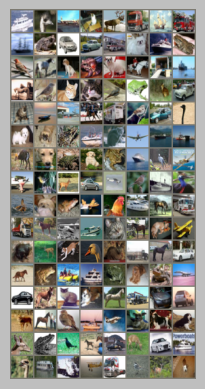

In [11]:
# DataLoader
trainloader = torch.utils.data.DataLoader(train_set, batch_size=128, shuffle=True, num_workers=4)
testloader = torch.utils.data.DataLoader(test_set, batch_size=256, shuffle=False, num_workers=4)

def denormalize(img, mean, std):
    mean = torch.tensor(mean).view(3, 1, 1)
    std = torch.tensor(std).view(3, 1, 1)
    return img * std + mean

# Show one batch of images
dataiter = iter(trainloader)
images, labels = next(dataiter)
img_grid = torchvision.utils.make_grid(images)
img_grid = denormalize(img_grid, mean, std)
plt.imshow(img_grid.permute(1, 2, 0).clamp(0, 1))
plt.axis('off')
plt.show()

### $\bullet\;$ CNN Model

model size: 38021440 bit | 4.75 MB


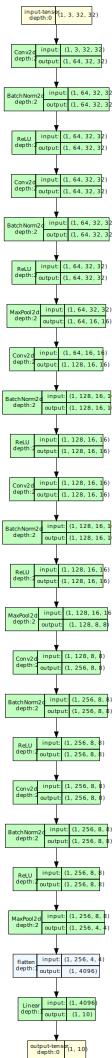

In [12]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # 7 layers total: 6 conv + final classifier
        self.features = nn.Sequential(
            # Block 1
            nn.Conv2d(3, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(),
            nn.Conv2d(64, 64, 3, padding=1), nn.BatchNorm2d(64), nn.ReLU(), nn.MaxPool2d(2),
            # Block 2
            nn.Conv2d(64, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(),
            nn.Conv2d(128, 128, 3, padding=1), nn.BatchNorm2d(128), nn.ReLU(), nn.MaxPool2d(2),
            # Block 3
            nn.Conv2d(128, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(),
            nn.Conv2d(256, 256, 3, padding=1), nn.BatchNorm2d(256), nn.ReLU(), nn.MaxPool2d(2)
        )
        self.classifier = nn.Linear(256 * 4 * 4, 10)

    def forward(self, x):
        x = self.features(x)
        # x = x.view(x.size(0), -1)
        x = torch.flatten(x, start_dim=1)
        x = self.classifier(x)
        return x

model = CNN()
batch_size = 2
size_model = 0
for param in model.parameters():
    if param.data.is_floating_point():
        size_model += param.numel() * torch.finfo(param.data.dtype).bits
    else:
        size_model += param.numel() * torch.iinfo(param.data.dtype).bits
print(f"model size: {size_model} bit | {size_model / 8e6:.2f} MB")

model_graph = draw_graph(model, input_size=(1, 3, 32, 32), device='meta')
display(model_graph.visual_graph)

In [13]:
def print_layer_outputs(model, input_size):
    x = torch.randn(input_size)
    print(f"Input: {x.shape}")
    count = 0
    for i, layer in enumerate(model.features):
        x = layer(x)
        if layer.__class__.__name__ in ['Conv2d']:
            count += 1
        print(f"Layer {count} ({layer.__class__.__name__}): {x.shape}")
    x = x.view(x.size(0), -1)
    print(f"Flatten: {x.shape}")
    x = model.classifier(x)
    print(f"Classifier Output: {x.shape}")

model = CNN().to('cpu')
print_layer_outputs(model, (1, 3, 32, 32))

Input: torch.Size([1, 3, 32, 32])
Layer 1 (Conv2d): torch.Size([1, 64, 32, 32])
Layer 1 (BatchNorm2d): torch.Size([1, 64, 32, 32])
Layer 1 (ReLU): torch.Size([1, 64, 32, 32])
Layer 2 (Conv2d): torch.Size([1, 64, 32, 32])
Layer 2 (BatchNorm2d): torch.Size([1, 64, 32, 32])
Layer 2 (ReLU): torch.Size([1, 64, 32, 32])
Layer 2 (MaxPool2d): torch.Size([1, 64, 16, 16])
Layer 3 (Conv2d): torch.Size([1, 128, 16, 16])
Layer 3 (BatchNorm2d): torch.Size([1, 128, 16, 16])
Layer 3 (ReLU): torch.Size([1, 128, 16, 16])
Layer 4 (Conv2d): torch.Size([1, 128, 16, 16])
Layer 4 (BatchNorm2d): torch.Size([1, 128, 16, 16])
Layer 4 (ReLU): torch.Size([1, 128, 16, 16])
Layer 4 (MaxPool2d): torch.Size([1, 128, 8, 8])
Layer 5 (Conv2d): torch.Size([1, 256, 8, 8])
Layer 5 (BatchNorm2d): torch.Size([1, 256, 8, 8])
Layer 5 (ReLU): torch.Size([1, 256, 8, 8])
Layer 6 (Conv2d): torch.Size([1, 256, 8, 8])
Layer 6 (BatchNorm2d): torch.Size([1, 256, 8, 8])
Layer 6 (ReLU): torch.Size([1, 256, 8, 8])
Layer 6 (MaxPool2d): to

In [14]:
from torchinfo import summary
summary(model, input_size=(1, 3, 32, 32))

Layer (type:depth-idx)                   Output Shape              Param #
CNN                                      [1, 10]                   --
├─Sequential: 1-1                        [1, 256, 4, 4]            --
│    └─Conv2d: 2-1                       [1, 64, 32, 32]           1,792
│    └─BatchNorm2d: 2-2                  [1, 64, 32, 32]           128
│    └─ReLU: 2-3                         [1, 64, 32, 32]           --
│    └─Conv2d: 2-4                       [1, 64, 32, 32]           36,928
│    └─BatchNorm2d: 2-5                  [1, 64, 32, 32]           128
│    └─ReLU: 2-6                         [1, 64, 32, 32]           --
│    └─MaxPool2d: 2-7                    [1, 64, 16, 16]           --
│    └─Conv2d: 2-8                       [1, 128, 16, 16]          73,856
│    └─BatchNorm2d: 2-9                  [1, 128, 16, 16]          256
│    └─ReLU: 2-10                        [1, 128, 16, 16]          --
│    └─Conv2d: 2-11                      [1, 128, 16, 16]          147,

In [15]:
size_model = 0
for param in model.parameters():
    if param.data.is_floating_point():
        size_model += param.numel()
    else:
        size_model += param.numel()

### $\bullet\;$ Train

#### loss, optimizer, scheduler

using CrossEntropyLoss

using Adam with lr=0.001, weight_decay=1e-4

In [16]:
# Select device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)

# loss, optimizer, scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=15)

In [17]:
# Training loop with loss tracking
epochs = 15
train_accs, test_accs, train_losses, test_losses = [], [], [], []
for epoch in range(1, epochs+1):
    model.train()
    correct, total = 0, 0
    running_loss = 0.0
    for i, (inputs, targets) in enumerate(trainloader, 1):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        _, preds = outputs.max(1)
        total += targets.size(0)
        correct += preds.eq(targets).sum().item()
        running_loss += loss.item() * inputs.size(0)
    train_accs.append(100.*correct/total)
    train_losses.append(running_loss / total)

    model.eval()
    correct, total = 0, 0
    running_loss = 0.0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = outputs.max(1)
            total += targets.size(0)
            correct += preds.eq(targets).sum().item()
            loss = criterion(outputs, targets)
            running_loss += loss.item() * inputs.size(0)
    test_acc = 100. * correct / total
    test_losses.append(running_loss / total)
    test_accs.append(test_acc)
    scheduler.step()
    print(f"Epoch {epoch:2d}: Train Acc = {train_accs[-1]:.2f}%, Test Acc = {test_acc:.2f}%")

Epoch  1: Train Acc = 53.05%, Test Acc = 63.44%
Epoch  2: Train Acc = 73.30%, Test Acc = 70.33%
Epoch  3: Train Acc = 79.97%, Test Acc = 75.88%
Epoch  4: Train Acc = 84.55%, Test Acc = 80.78%
Epoch  5: Train Acc = 88.29%, Test Acc = 80.43%
Epoch  6: Train Acc = 91.91%, Test Acc = 82.09%
Epoch  7: Train Acc = 95.18%, Test Acc = 80.11%
Epoch  8: Train Acc = 97.83%, Test Acc = 83.35%
Epoch  9: Train Acc = 99.48%, Test Acc = 86.12%
Epoch 10: Train Acc = 99.95%, Test Acc = 86.92%
Epoch 11: Train Acc = 100.00%, Test Acc = 87.07%
Epoch 12: Train Acc = 100.00%, Test Acc = 87.04%
Epoch 13: Train Acc = 100.00%, Test Acc = 87.25%
Epoch 14: Train Acc = 100.00%, Test Acc = 87.13%
Epoch 15: Train Acc = 100.00%, Test Acc = 87.29%


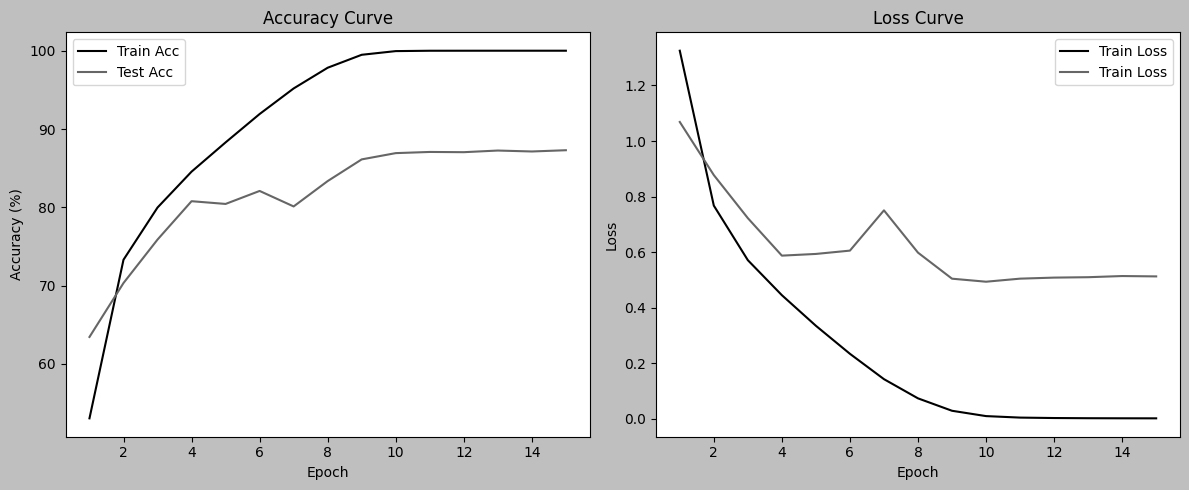

In [18]:
# Plot accuracy and loss curves
eps = range(1, epochs+1)
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(eps, train_accs, label='Train Acc')
plt.plot(eps, test_accs, label='Test Acc')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.title('Accuracy Curve')

plt.subplot(1,2,2)
plt.plot(eps, train_losses, label='Train Loss')
plt.plot(eps, test_losses, label='Train Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss Curve')

plt.tight_layout()
plt.show()

## Export ONNX

In [17]:
dummy_input = torch.randn(1, 3, 32, 32, requires_grad=False)
dummy_input = dummy_input.to(device)
torch.onnx.export(model,                       # Your model
                  dummy_input,                 # Sample input
                  "/kaggle/working/base_model_out.onnx",              # Path to save the ONNX file
                  export_params=True,          # Store the trained weights
                  opset_version=11,            # ONNX opset version (or a version compatible with ONNX2C)
                  do_constant_folding=True,    # Execute constant folding optimization
                  input_names = ['input_image'], # Custom name for the input layer
                  output_names = ['predictions'],# Custom name for the output layer
                  dynamic_axes={'input_image' : {0 : 'batch_size'}, # Allow for dynamic batch_size
                                'predictions' : {0 : 'batch_size'}})

In [46]:
def convert_to_onnx(model, name):
    dummy_input = torch.randn(1, 3, 32, 32, requires_grad=False)
    dummy_input = dummy_input.to(device)
    torch.onnx.export(model,                       # Your model
                      dummy_input,                 # Sample input
                      "/kaggle/working/" + name,              # Path to save the ONNX file
                      export_params=True,          # Store the trained weights
                      opset_version=11,            # ONNX opset version (or a version compatible with ONNX2C)
                      do_constant_folding=True,    # Execute constant folding optimization
                      input_names = ['input_image'], # Custom name for the input layer
                      output_names = ['predictions'],# Custom name for the output layer
                      dynamic_axes={'input_image' : {0 : 'batch_size'}, # Allow for dynamic batch_size
                                    'predictions' : {0 : 'batch_size'}})

In [18]:
!apt install libprotobuf-dev protobuf-compiler -y

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
The following additional packages will be installed:
  libprotobuf-lite23 libprotobuf23 libprotoc23
Suggested packages:
  protobuf-mode-el
The following NEW packages will be installed:
  libprotobuf-dev libprotobuf-lite23
The following packages will be upgraded:
  libprotobuf23 libprotoc23 protobuf-compiler
3 upgraded, 2 newly installed, 0 to remove and 84 not upgraded.
Need to get 3,124 kB of archives.
After this operation, 12.2 MB of additional disk space will be used.
Get:1 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libprotobuf-lite23 amd64 3.12.4-1ubuntu7.22.04.2 [209 kB]
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 libprotobuf23 amd64 3.12.4-1ubuntu7.22.04.2 [877 kB]
Get:3 http://archive.ubuntu.com/ubuntu jammy-updates/universe amd64 protobuf-compiler amd64 3.12.4-1ubuntu7.22.04.2 [29.2 kB]
Get:4 http://archive.ubuntu.com/ubuntu jammy-updates/main amd6

In [19]:
!git clone https://github.com/kraiskil/onnx2c.git
%cd onnx2c
!git submodule update --init

Cloning into 'onnx2c'...
remote: Enumerating objects: 2476, done.
remote: Counting objects: 100% (501/501), done.
remote: Compressing objects: 100% (143/143), done.
remote: Total 2476 (delta 439), reused 367 (delta 356), pack-reused 1975 (from 1)
Receiving objects: 100% (2476/2476), 30.13 MiB | 39.01 MiB/s, done.
Resolving deltas: 100% (1593/1593), done.
/kaggle/working/onnx2c
Submodule 'aixlog' (https://github.com/badaix/aixlog.git) registered for path 'aixlog'
Submodule 'args' (https://github.com/Taywee/args.git) registered for path 'args'
Submodule 'benchmark' (https://github.com/google/benchmark.git) registered for path 'benchmark'
Submodule 'cmake_timestamp' (https://github.com/kraiskil/cmake_timestamp.git) registered for path 'cmake_timestamp'
Submodule 'onnx' (https://github.com/onnx/onnx.git) registered for path 'onnx'
Cloning into '/kaggle/working/onnx2c/aixlog'...
Cloning into '/kaggle/working/onnx2c/args'...
Cloning into '/kaggle/working/onnx2c/benchmark'...
Cloning into '/k

In [20]:
!mkdir build
%cd build
!cmake -DCMAKE_BUILD_TYPE=Release ..
!make onnx2c

/kaggle/working/onnx2c/build
-- The C compiler identification is GNU 11.4.0
-- The CXX compiler identification is GNU 11.4.0
-- Detecting C compiler ABI info
-- Detecting C compiler ABI info - done
-- Check for working C compiler: /usr/bin/cc - skipped
-- Detecting C compile features
-- Detecting C compile features - done
-- Detecting CXX compiler ABI info
-- Detecting CXX compiler ABI info - done
-- Check for working CXX compiler: /usr/bin/c++ - skipped
-- Detecting CXX compile features
-- Detecting CXX compile features - done
-- Found Git: /usr/bin/git (found version "2.34.1")
-- Found Protobuf: /usr/lib/x86_64-linux-gnu/libprotobuf.so (found version "3.12.4")
CMake Deprecation Warning at benchmark/CMakeLists.txt:1 (cmake_minimum_required):
  Compatibility with CMake < 3.10 will be removed from a future version of
  CMake.

  Update the VERSION argument <min> value.  Or, use the <min>...<max> syntax
  to tell CMake that the project requires at least <min> but has been updated
  to wo

In [21]:
!./onnx2c --help

  ./onnx2c [input] {OPTIONS}

    Generate C code from an ONNX graph file.

  OPTIONS:

      -a, --avr                         Target AVR-GCC
      -n, --no-globals                  Do not generate global tensors
      -d[dim:size...],
      --define=[dim:size...]            Define graph input dimension. Can be
                                        given multiple times
      -l[level], --log=[level]          Logging verbosity. 0(none)-4(all)
      -p[opt[,opt]...],
      --optimizations=[opt[,opt]...]    Specify optimization passes to run.
                                        ('help' to list available)
      -h, --help                        Print this help text.
      -q, --quantize                    Quantize network (EXPERIMENTAL!)
      -v, --version                     Print onnx2c version
      input                             ONNX file to process
      "--" can be used to terminate flag options and force all following
      arguments to be treated as positional options



In [22]:
!./onnx2c /kaggle/working/base_model_out.onnx > /kaggle/working/base_model_out.c

2025-06-07 07-56-48.610 [Warn] (getIoTensor) Graph input tensor dimension (batch_size) not specified!
2025-06-07 07-56-48.610 [Warn] (getIoTensor) Specify with command line option '-d batch_size:<value>'
2025-06-07 07-56-48.610 [Warn] (getIoTensor) Defining this dimension as 1 for now.


In [23]:
!./onnx2c /kaggle/working/base_model_out.onnx -d batch_size:1 > /kaggle/working/base_model_out.c

# Phase 2

In [19]:
import copy
import torch.nn.utils.prune as prune

baseline_model = copy.deepcopy(model)

In [20]:
def test(model):
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in testloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    return 100.*correct/total

## Q1-بررسی هرس یکباره

ابتدا از روش کاملا تصادفی استفاده می کنیم. در این روش بدون توجه به هیچ چیزی شروع به هرس می کنیم و برایمان تفاوتی بین وزن ها و یال ها وجود ندارد.

Random unstructured prune 20%, acc: 30.74%
Random unstructured prune 30%, acc: 14.27%
Random unstructured prune 40%, acc: 10.00%
Random unstructured prune 50%, acc: 12.90%
Random unstructured prune 60%, acc: 10.00%
Random unstructured prune 70%, acc: 10.00%
Random unstructured prune 80%, acc: 10.14%


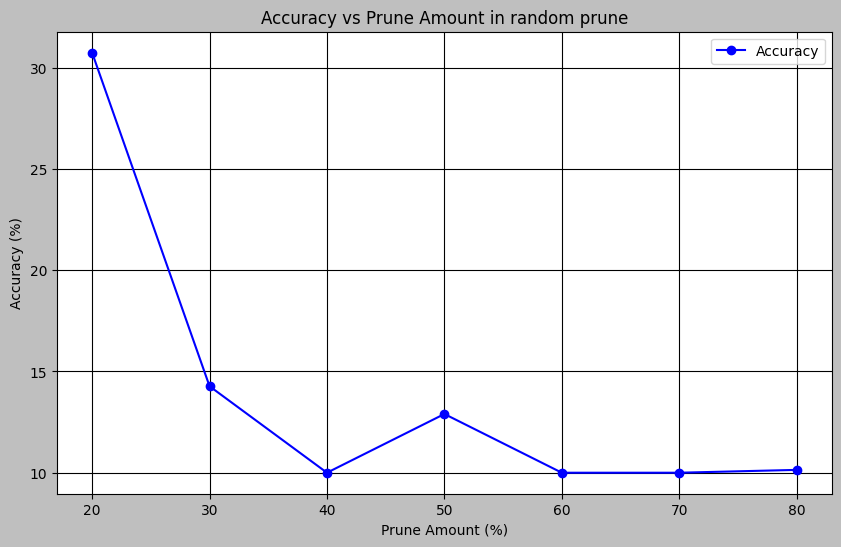

In [26]:
import matplotlib.pyplot as plt

pruned_models = []
prune_amounts = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
accuracies = []

rand_model = dict()

for amount in prune_amounts:
    model_copy = copy.deepcopy(baseline_model)
    for module in model_copy.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prune.random_unstructured(module, name='weight', amount=amount)
    pruned_models.append(model_copy)
    acc = test(model_copy)
    accuracies.append(acc) 
    rand_model[amount] = model_copy
    print(f'Random unstructured prune {amount*100:.0f}%, acc: {acc:.2f}%')

plt.figure(figsize=(10, 6))
plt.plot([amount * 100 for amount in prune_amounts], accuracies, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Prune Amount (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Prune Amount in random prune')
plt.grid(True)
plt.legend()
plt.show()

همانطور که انتظار داشتیم این روش اصلا مناسب نیست و از همان ابتدا دقت مدل را نصف می کند

حال از l1_unstructured استفاده می کنیم که در این روش وزن هایی که قدر مطلق آنها به صفر نزندیک تر است حذف می شود. در مقابل آن l2 رو داریم که به جای قدر مطلق از توان ۲ 
استفاده می کند

l1 unstructured prune 20%, acc: 87.60%
l1 unstructured prune 30%, acc: 86.21%
l1 unstructured prune 40%, acc: 83.60%
l1 unstructured prune 50%, acc: 59.74%
l1 unstructured prune 60%, acc: 32.90%
l1 unstructured prune 70%, acc: 22.57%
l1 unstructured prune 80%, acc: 10.54%


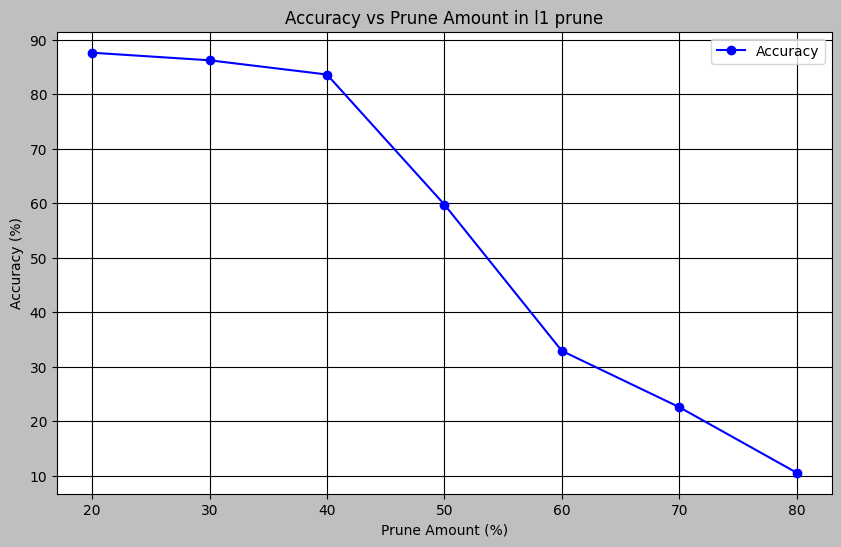

In [27]:
pruned_models = []
prune_amounts = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
accuracies = []

l1_uns_model = dict()

for amount in prune_amounts:
    model_copy = copy.deepcopy(baseline_model)
    for module in model_copy.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            prune.l1_unstructured(module, name='weight', amount=amount)
    pruned_models.append(model_copy)
    acc = test(model_copy)
    accuracies.append(acc) 
    l1_uns_model[amount] = model_copy
    print(f'l1 unstructured prune {amount*100:.0f}%, acc: {acc:.2f}%')

plt.figure(figsize=(10, 6))
plt.plot([amount * 100 for amount in prune_amounts], accuracies, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Prune Amount (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Prune Amount in l1 prune')
plt.grid(True)
plt.legend()
plt.show()

همانطور که در نمودار مشخص است هرس تا ۲۰ درصد تقریبا بی تاثیر است ولی باقی موارد بیش از ۱ درصد تاثیر دارند که مناسب نیست و همچنین افت دقت شدیدی بعد از حذف ۶۰ درصد شامل هستیم که دقت نصف شده

باید توجه کرد که در این روش ما با پیمایش روی شبکه در هر لایه به صورت جداگانه حرص انجام می دهیم. می شود با تجمیع وزن ها نیز این کار را انجام داد. از آنجایی که روش اول تصادفی است در نتیجه آن تفاوتی ایجاد نمی شود اما ممکن است در روش دوم تفاوت ایجاد کند که در ادامه بررسی می کنیم..

l1-global unstructured prune 20%, acc: 87.77%
l1-global unstructured prune 30%, acc: 87.36%
l1-global unstructured prune 40%, acc: 86.29%
l1-global unstructured prune 50%, acc: 82.58%
l1-global unstructured prune 60%, acc: 64.10%
l1-global unstructured prune 70%, acc: 37.29%
l1-global unstructured prune 80%, acc: 15.74%


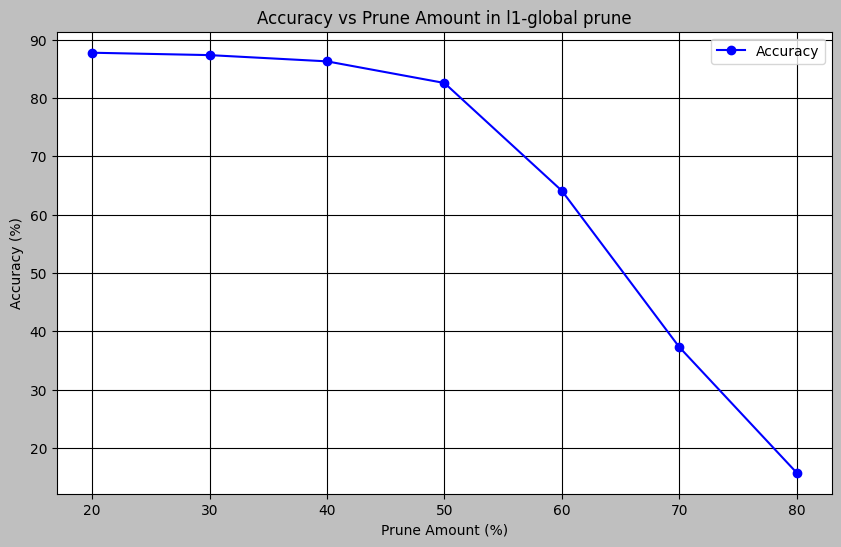

In [28]:
pruned_models = []
prune_amounts = [0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8]
accuracies = []

l1_uns_glo_model = dict()

parameters_to_prune = []
for module in baseline_model.modules():
    if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
        parameters_to_prune.append((module, 'weight'))

for amount in prune_amounts:
    model_copy = copy.deepcopy(baseline_model)
    parameters = []
    for module in model_copy.modules():
        if isinstance(module, nn.Conv2d) or isinstance(module, nn.Linear):
            parameters.append((module, 'weight'))

    prune.global_unstructured(
        parameters,
        pruning_method=prune.L1Unstructured,
        amount=amount,
    )
    
    pruned_models.append(model_copy)
    acc = test(model_copy)
    accuracies.append(acc) 
    l1_uns_glo_model[amount] = model_copy
    print(f'l1-global unstructured prune {amount*100:.0f}%, acc: {acc:.2f}%')

plt.figure(figsize=(10, 6))
plt.plot([amount * 100 for amount in prune_amounts], accuracies, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Prune Amount (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Prune Amount in l1-global prune')
plt.grid(True)
plt.legend()
plt.show()

همانطور که در نمودار مشخص است با این کار تقریبا تا ۴۰ درصد حرص قابل قبول است پس با این کار تحمل مدل در حرص ۲ برابر شد

## Q2- هرس مرحله به مرحله

In [21]:
def train(epochs):
    for epoch in range(1, epochs + 1):
        model.train()
        correct, total = 0, 0
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(trainloader, 1):
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()
            _, preds = outputs.max(1)
            total += targets.size(0)
            correct += preds.eq(targets).sum().item()
            running_loss += loss.item() * inputs.size(0)

        train_accs.append(100. * correct / total)
        train_losses.append(running_loss / total)

        model.eval()
        correct, total = 0, 0
        running_loss = 0.0
        with torch.no_grad():
            for inputs, targets in testloader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                _, preds = outputs.max(1)
                total += targets.size(0)
                correct += preds.eq(targets).sum().item()
                loss = criterion(outputs, targets)
                running_loss += loss.item() * inputs.size(0)

        test_acc = 100. * correct / total
        test_accs.append(test_acc)
        test_losses.append(running_loss / total)
        scheduler.step()

        print(f"Epoch {epoch}/{epochs} - Train Acc: {train_accs[-1]:.2f}%, Test Acc: {test_acc:.2f}%")


Epoch 1/4 - Train Acc: 96.14%, Test Acc: 83.34%
Epoch 2/4 - Train Acc: 98.23%, Test Acc: 85.48%
Epoch 3/4 - Train Acc: 99.81%, Test Acc: 87.04%
Epoch 4/4 - Train Acc: 99.99%, Test Acc: 87.53%
Pruned to 20%, Accuracy: 87.53%
Epoch 1/4 - Train Acc: 97.84%, Test Acc: 84.16%
Epoch 2/4 - Train Acc: 98.81%, Test Acc: 85.23%
Epoch 3/4 - Train Acc: 99.85%, Test Acc: 87.19%
Epoch 4/4 - Train Acc: 100.00%, Test Acc: 87.58%
Pruned to 30%, Accuracy: 87.58%
Epoch 1/4 - Train Acc: 98.33%, Test Acc: 85.12%
Epoch 2/4 - Train Acc: 99.63%, Test Acc: 85.89%
Epoch 3/4 - Train Acc: 99.97%, Test Acc: 87.91%
Epoch 4/4 - Train Acc: 100.00%, Test Acc: 87.89%
Pruned to 40%, Accuracy: 87.89%
Epoch 1/4 - Train Acc: 98.97%, Test Acc: 84.35%
Epoch 2/4 - Train Acc: 99.61%, Test Acc: 86.61%
Epoch 3/4 - Train Acc: 99.97%, Test Acc: 87.41%
Epoch 4/4 - Train Acc: 100.00%, Test Acc: 87.66%
Pruned to 50%, Accuracy: 87.66%
Epoch 1/4 - Train Acc: 99.34%, Test Acc: 85.58%
Epoch 2/4 - Train Acc: 99.86%, Test Acc: 86.15%
Epoch

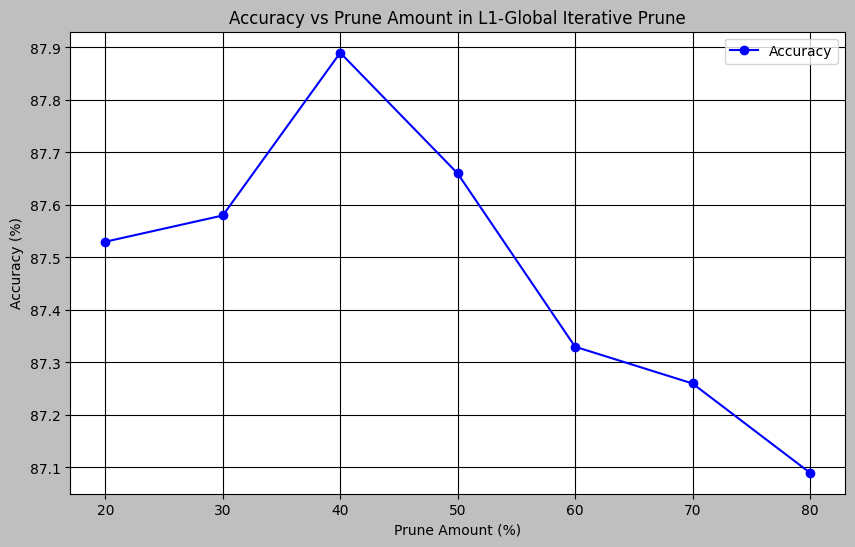

In [30]:
start_prune = 0.2
end_prune = 0.8
step_count = int((end_prune - start_prune) / 0.1) + 1
fine_tune_epochs = 4

model = copy.deepcopy(baseline_model)
parameters_to_prune = [
    (m, 'weight') for m in model.modules()
    if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear)
]

accuracies = []
prune_levels = []

l1_uns_glob_step = dict()

current_pruned = 0.0
target_pruned_list = [round(p, 2) for p in list(torch.arange(start_prune, end_prune + 0.001, 0.1).tolist())]

for target in target_pruned_list:
    remaining = 1.0 - current_pruned
    step_amount = (target - current_pruned) / remaining  

    prune.global_unstructured(
        parameters_to_prune,
        pruning_method=prune.L1Unstructured,
        amount=step_amount
    )
    current_pruned = target

    # loss, optimizer, scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=fine_tune_epochs)

    train(fine_tune_epochs)

    acc = test(model)
    accuracies.append(acc)
    prune_levels.append(target * 100)
    l1_uns_glob_step[target] = copy.deepcopy(model)
    print(f'Pruned to {target*100:.0f}%, Accuracy: {acc:.2f}%')

plt.figure(figsize=(10, 6))
plt.plot(prune_levels, accuracies, marker='o', linestyle='-', color='b', label='Accuracy')
plt.xlabel('Prune Amount (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Prune Amount in L1-Global Iterative Prune')
plt.grid(True)
plt.legend()
plt.show()

با این کار دقت مدل تا ۵۰ درصد خوب است و ختی از ۴۰ درصد حالت قبلی بهتر است و همچنین دقت تمامی حالات بالا تر است مثلا در هرس ۸۰ درصد دقت ۶۳ درصد می شود در مقابل ۲۴ درصد

## Q3- هرس ساختارمند

Epoch 1/4 - Train Acc: 93.33%, Test Acc: 80.72%
Epoch 2/4 - Train Acc: 97.37%, Test Acc: 83.87%
Epoch 3/4 - Train Acc: 99.45%, Test Acc: 86.24%
Epoch 4/4 - Train Acc: 100.00%, Test Acc: 87.23%
L2 Structured Pruned to 20%, Accuracy: 87.23%
Epoch 1/4 - Train Acc: 94.44%, Test Acc: 76.28%
Epoch 2/4 - Train Acc: 97.94%, Test Acc: 84.18%
Epoch 3/4 - Train Acc: 99.73%, Test Acc: 86.30%
Epoch 4/4 - Train Acc: 100.00%, Test Acc: 86.77%
L2 Structured Pruned to 30%, Accuracy: 86.77%
Epoch 1/4 - Train Acc: 94.54%, Test Acc: 74.87%
Epoch 2/4 - Train Acc: 98.22%, Test Acc: 73.24%
Epoch 3/4 - Train Acc: 99.78%, Test Acc: 86.25%
Epoch 4/4 - Train Acc: 100.00%, Test Acc: 86.55%
L2 Structured Pruned to 40%, Accuracy: 86.55%
Epoch 1/4 - Train Acc: 94.31%, Test Acc: 62.20%
Epoch 2/4 - Train Acc: 97.78%, Test Acc: 82.48%
Epoch 3/4 - Train Acc: 99.69%, Test Acc: 85.09%
Epoch 4/4 - Train Acc: 100.00%, Test Acc: 85.67%
L2 Structured Pruned to 50%, Accuracy: 85.67%
Epoch 1/4 - Train Acc: 90.81%, Test Acc: 78.

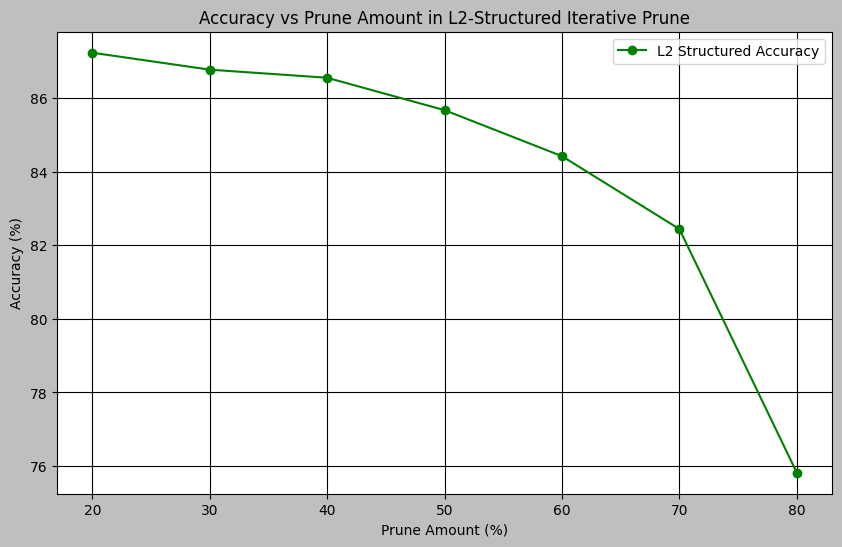

In [31]:
start_prune = 0.2
end_prune = 0.8
step_count = int((end_prune - start_prune) / 0.1) + 1
fine_tune_epochs = 4

model = copy.deepcopy(baseline_model)

accuracies = []
prune_levels = []

l2_struc_step_model = dict()

current_pruned = 0.0
target_pruned_list = [round(p, 2) for p in list(torch.arange(start_prune, end_prune + 0.001, 0.1).tolist())]

for target in target_pruned_list:
    remaining = 1.0 - current_pruned
    step_amount = (target - current_pruned) / remaining 

    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            prune.ln_structured(module, name='weight', amount=step_amount, n=2, dim=0) 

    current_pruned = target

    # loss, optimizer, scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=fine_tune_epochs)

    train(fine_tune_epochs)

    acc = test(model)
    accuracies.append(acc)
    prune_levels.append(target * 100)
    l2_struc_step_model[target] = copy.deepcopy(model)
    print(f'L2 Structured Pruned to {target*100:.0f}%, Accuracy: {acc:.2f}%')

plt.figure(figsize=(10, 6))
plt.plot(prune_levels, accuracies, marker='o', linestyle='-', color='g', label='L2 Structured Accuracy')
plt.xlabel('Prune Amount (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Prune Amount in L2-Structured Iterative Prune')
plt.grid(True)
plt.legend()
plt.show()

Epoch 1/4 - Train Acc: 93.68%, Test Acc: 79.34%
Epoch 2/4 - Train Acc: 96.80%, Test Acc: 81.35%
Epoch 3/4 - Train Acc: 99.40%, Test Acc: 86.23%
Epoch 4/4 - Train Acc: 99.98%, Test Acc: 87.25%
L2 Structured Pruned to 20%, Accuracy: 87.25%
Epoch 1/4 - Train Acc: 94.88%, Test Acc: 75.35%
Epoch 2/4 - Train Acc: 97.79%, Test Acc: 83.55%
Epoch 3/4 - Train Acc: 99.71%, Test Acc: 86.19%
Epoch 4/4 - Train Acc: 100.00%, Test Acc: 87.00%
L2 Structured Pruned to 30%, Accuracy: 87.00%
Epoch 1/4 - Train Acc: 94.91%, Test Acc: 76.67%
Epoch 2/4 - Train Acc: 98.06%, Test Acc: 83.16%
Epoch 3/4 - Train Acc: 99.76%, Test Acc: 85.67%
Epoch 4/4 - Train Acc: 99.99%, Test Acc: 86.32%
L2 Structured Pruned to 40%, Accuracy: 86.32%
Epoch 1/4 - Train Acc: 94.03%, Test Acc: 80.22%
Epoch 2/4 - Train Acc: 97.95%, Test Acc: 83.20%
Epoch 3/4 - Train Acc: 99.66%, Test Acc: 84.72%
Epoch 4/4 - Train Acc: 99.99%, Test Acc: 85.54%
L2 Structured Pruned to 50%, Accuracy: 85.54%
Epoch 1/4 - Train Acc: 90.41%, Test Acc: 73.19%

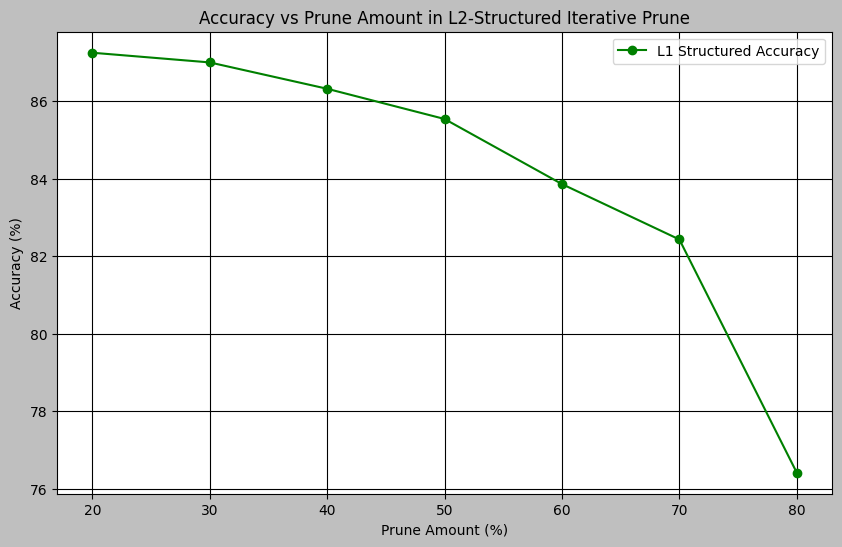

In [32]:
start_prune = 0.2
end_prune = 0.8
step_count = int((end_prune - start_prune) / 0.1) + 1
fine_tune_epochs = 4

model = copy.deepcopy(baseline_model)

accuracies = []
prune_levels = []

l1_struc_step_model = dict()

current_pruned = 0.0
target_pruned_list = [round(p, 2) for p in list(torch.arange(start_prune, end_prune + 0.001, 0.1).tolist())]

for target in target_pruned_list:
    remaining = 1.0 - current_pruned
    step_amount = (target - current_pruned) / remaining 

    for module in model.modules():
        if isinstance(module, nn.Conv2d):
            prune.ln_structured(module, name='weight', amount=step_amount, n=1, dim=0) 

    current_pruned = target

    # loss, optimizer, scheduler
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=fine_tune_epochs)

    train(fine_tune_epochs)

    acc = test(model)
    accuracies.append(acc)
    prune_levels.append(target * 100)
    l1_struc_step_model[target] = copy.deepcopy(model)
    print(f'L2 Structured Pruned to {target*100:.0f}%, Accuracy: {acc:.2f}%')

plt.figure(figsize=(10, 6))
plt.plot(prune_levels, accuracies, marker='o', linestyle='-', color='g', label='L1 Structured Accuracy')
plt.xlabel('Prune Amount (%)')
plt.ylabel('Accuracy (%)')
plt.title('Accuracy vs Prune Amount in L2-Structured Iterative Prune')
plt.grid(True)
plt.legend()
plt.show()

# Phase 3

## Adding file in block (for using in kaggle)

In [22]:
import copy
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

class Quantize(torch.nn.Module):
    def __init__(self, n_bits, n_frac, sign=True):
        super(Quantize, self).__init__()
        self.n_bits = n_bits
        self.n_frac = n_frac
        i = self.n_bits - self.n_frac
        if sign:
            self.max = float(2 ** (i - 1) - 2 ** (-self.n_frac))
            self.min = float(-2 ** (i - 1))
        else:
            self.max = float(2 ** (i) - 2 ** (-self.n_frac))
            self.min = 0.0

    def forward(self, x):
        if torch.onnx.is_in_onnx_export():
            return x
        else:
            n = float(2 ** self.n_frac)
            xx = torch.floor(x * n) / n
            clipped = torch.clip(xx, self.min, self.max)
            return clipped

class Round(Function):
    @staticmethod
    def forward(self, input):
        sign = torch.sign(input)
        output = sign * torch.floor(torch.abs(input) + 0.5)
        return output

    @staticmethod
    def backward(self, grad_output):
        grad_input = grad_output.clone()
        return grad_input

class ALSQPlus(Function):
    @staticmethod
    def forward(ctx, weight, alpha, beta, g, Qn, Qp):
        ctx.save_for_backward(weight, alpha, beta)
        ctx.other = g, Qn, Qp
        w_q = Round.apply(torch.div((weight - beta), alpha).clamp(Qn, Qp))
        w_q = w_q * alpha + beta
        return w_q

    @staticmethod
    def backward(ctx, grad_weight):
        weight, alpha, beta = ctx.saved_tensors
        g, Qn, Qp = ctx.other
        q_w = (weight - beta) / alpha
        smaller = (q_w < Qn).float()
        bigger = (q_w > Qp).float()
        between = 1.0 - smaller -bigger
        grad_alpha = ((smaller * Qn + bigger * Qp +
            between * Round.apply(q_w) - between * q_w)*grad_weight * g).sum().unsqueeze(dim=0)
        grad_beta = ((smaller + bigger) * grad_weight * g).sum().unsqueeze(dim=0)
        grad_weight = between * grad_weight
        return grad_weight, grad_alpha, grad_beta, None, None, None


class WLSQPlus(Function):
    @staticmethod
    def forward(ctx, weight, alpha, g, Qn, Qp, per_channel):
        ctx.save_for_backward(weight, alpha)
        ctx.other = g, Qn, Qp, per_channel
        if per_channel:
            sizes = weight.size()
            # weight = weight.contiguous().view(weight.size()[0], -1)
            weight = weight.view(weight.size()[0], -1)
            weight = torch.transpose(weight, 0, 1)
            alpha = torch.broadcast_to(alpha, weight.size())
            wq = Round.apply(torch.div(weight, alpha).clamp(Qn, Qp))
            w_q = wq * alpha
            w_q = torch.transpose(w_q, 0, 1)
            # w_q = w_q.contiguous().view(sizes)
            w_q = w_q.view(sizes)
            wq = torch.transpose(wq, 0, 1).view(sizes)
        else:
            wq = Round.apply(torch.div(weight, alpha).clamp(Qn, Qp))
            w_q = wq * alpha
        return w_q, wq.detach()

    @staticmethod
    def backward(ctx, grad_weight, gwq):
        weight, alpha = ctx.saved_tensors
        g, Qn, Qp, per_channel = ctx.other
        if per_channel:
            sizes = weight.size()
            # weight = weight.contiguous().view(weight.size()[0], -1)
            weight = weight.view(weight.size()[0], -1)
            weight = torch.transpose(weight, 0, 1)
            alpha = torch.broadcast_to(alpha, weight.size())
            q_w = weight / alpha
            q_w = torch.transpose(q_w, 0, 1)
            # q_w = q_w.contiguous().view(sizes)
            q_w = q_w.view(sizes)
        else:
            q_w = weight / alpha
        smaller = (q_w < Qn).float()
        bigger = (q_w > Qp).float()
        between = 1.0 - smaller -bigger
        if per_channel:
            grad_alpha = ((smaller * Qn + bigger * Qp +
                between * Round.apply(q_w) - between * q_w)*grad_weight * g)
            # grad_alpha = grad_alpha.contiguous().view(grad_alpha.size()[0], -1).sum(dim=1)
            grad_alpha = grad_alpha.view(grad_alpha.size()[0], -1).sum(dim=1)
        else:
            grad_alpha = ((smaller * Qn + bigger * Qp +
                between * Round.apply(q_w) - between * q_w)*grad_weight * g).sum().unsqueeze(dim=0)
        grad_weight = between * grad_weight
        return grad_weight, grad_alpha, None, None, None, None

class LSQPlusActivationQuantizer(nn.Module):
    def __init__(self, a_bits, all_positive=False,batch_init = 20):
        super(LSQPlusActivationQuantizer, self).__init__()
        self.a_bits = nn.Parameter(torch.tensor(a_bits), requires_grad=False)
        self.s_bits = 20
        self.n = 1 << 16
        self.all_positive = all_positive
        self.batch_init = batch_init
        if self.all_positive:
            # unsigned activation is quantized to [0, 2^b-1]
            self.Qn = 0
            self.Qp = 2 ** a_bits - 1
        else:
            # signed weight/activation is quantized to [-2^(b-1), 2^(b-1)-1]
            self.Qn = - 2 ** (a_bits - 1)
            self.Qp = 2 ** (a_bits - 1) - 1
        self.s = torch.nn.Parameter(torch.ones(1).squeeze(0), requires_grad=True)
        self.beta = torch.nn.Parameter(torch.ones(1).squeeze(0), requires_grad=True)
        self.g = torch.nn.Parameter(torch.ones(1).squeeze(0), requires_grad=True)
        self.register_buffer('init_state', torch.zeros(1))

    def forward(self, activation):
        if self.training:
            if self.init_state==0:
                self.g.data = torch.tensor(1.0/math.sqrt(activation.numel() * self.Qp))
                mina = torch.min(activation.detach())
                self.s.data = (torch.max(activation.detach()) - mina)/(self.Qp-self.Qn)
                self.beta.data = mina - self.s.data *self.Qn
                self.init_state += 1
            elif self.init_state<self.batch_init:
                mina = torch.min(activation.detach())
                self.s.data = self.s.data*0.9 + 0.1*(torch.max(activation.detach()) - mina)/(self.Qp-self.Qn)
                self.beta.data = self.s.data*0.9 + 0.1* (mina - self.s.data * self.Qn)
                self.init_state += 1
            elif self.init_state==self.batch_init:
                self.init_state += 1

        if self.a_bits.item() == 32:
            q_a = activation
        elif self.a_bits.item() == 1:
            print('！Binary quantization is not supported ！')
            assert self.a_bits.item() != 1
        else:
            q_a = ALSQPlus.apply(activation, self.s, self.beta, self.g, self.Qn, self.Qp)
        return q_a

class LSQPlusWeightQuantizer(nn.Module):
    def __init__(self, w_bits, all_positive=False, per_channel=False, batch_init = 20, shape=(1,), saved=True):
        super(LSQPlusWeightQuantizer, self).__init__()
        self.w_bits = nn.Parameter(torch.tensor(w_bits), requires_grad=False)
        self.s_bits = 20
        self.n = 1 << 16
        self.all_positive = all_positive
        self.batch_init = batch_init
        if self.all_positive:
            # unsigned activation is quantized to [0, 2^b-1]
            self.Qn = 0
            self.Qp = 2 ** w_bits - 1
        else:
            # signed weight/activation is quantized to [-2^(b-1), 2^(b-1)-1]
            self.Qn = - 2 ** (w_bits - 1)
            self.Qp = 2 ** (w_bits - 1) - 1
        self.per_channel = per_channel
        self.register_buffer('init_state', torch.zeros(1))
        if not per_channel:
           self.s = torch.nn.Parameter(torch.ones(1).squeeze(0), requires_grad=True)
        else:
            self.s = torch.nn.Parameter(torch.ones(shape[0]), requires_grad=True)

        self.saved = saved
        if saved:
            self.wq = torch.nn.Parameter(torch.ones(shape), requires_grad=True)
        self.g = torch.nn.Parameter(torch.ones(1).squeeze(0), requires_grad=True)
        
    def forward(self, weight):
        '''
        For this work, each layer of weights and each layer of activations has a distinct step size, represented
as an fp32 value, initialized to 2h|v|i/√OP , computed on either the initial weights values or the first
batch of activations, respectively
        '''
        if self.training:
            if self.init_state==0:
                self.div = 2**self.w_bits.item()-1
                self.g.data = torch.tensor(1.0/math.sqrt(weight.numel() * self.Qp))
                if self.per_channel:
                    # weight_tmp = weight.detach().contiguous().view(weight.size()[0], -1)
                    weight_tmp = weight.detach().view(weight.size()[0], -1)
                    mean = torch.mean(weight_tmp, dim=1)
                    std = torch.std(weight_tmp, dim=1)
                    v, _ = torch.max(torch.stack([torch.abs(mean-3*std), torch.abs(mean + 3*std)]), dim=0)
                    self.s.data = v/self.div
                else:
                    mean = torch.mean(weight.detach())
                    std = torch.std(weight.detach())
                    self.s.data = max([torch.abs(mean-3*std), torch.abs(mean + 3*std)])/self.div
                self.init_state += 1
            elif self.init_state<self.batch_init:
                self.div = 2**self.w_bits.item()-1
                if self.per_channel:
                    # weight_tmp = weight.detach().contiguous().view(weight.size()[0], -1)
                    weight_tmp = weight.detach().view(weight.size()[0], -1)
                    mean = torch.mean(weight_tmp, dim=1)
                    std = torch.std(weight_tmp, dim=1)
                    v, _ = torch.max(torch.stack([torch.abs(mean-3*std), torch.abs(mean + 3*std)]), dim=0)
                    self.s.data = v*0.9 + 0.1*v/self.div
                else:
                    mean = torch.mean(weight.detach())
                    std = torch.std(weight.detach())
                    self.s.data = self.s.data*0.9 + 0.1*max([torch.abs(mean-3*std), torch.abs(mean + 3*std)])/self.div
                self.init_state += 1
            elif self.init_state==self.batch_init:
                self.init_state += 1

        if self.w_bits.item() == 32:
            w_q = weight
        elif self.w_bits.item() == 1:
            print('！Binary quantization is not supported ！')
            assert self.w_bits.item() != 1
        else:
            if self.saved:
                w_q, self.wq.data = WLSQPlus.apply(weight, self.s, self.g, self.Qn, self.Qp, self.per_channel)
            else:
                w_q, _ = WLSQPlus.apply(weight, self.s, self.g, self.Qn, self.Qp, self.per_channel)

        return w_q

class QuantConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, 
                 w_bits=8, a_bits=8, all_positive=False, per_channel=False, batch_init=20):
        super(QuantConv2d, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        
        # Weight quantizer
        shape = self.weight.shape
        self.weight_quantizer = LSQPlusWeightQuantizer(w_bits, all_positive, per_channel, batch_init, shape)
        
        # Activation quantizer
        self.act_quantizer = LSQPlusActivationQuantizer(a_bits, all_positive, batch_init)
    
    def forward(self, x):
        # Quantize input activations
        x_q = self.act_quantizer(x)
        
        # Quantize weights
        w_q = self.weight_quantizer(self.weight)
        
        # Use quantized values for convolution
        output = F.conv2d(
            x_q, w_q, self.bias, self.stride, self.padding, self.dilation, self.groups
        )
        
        return output


class QuantLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, 
                 w_bits=8, a_bits=8, all_positive=False, per_channel=False, batch_init=20):
        super(QuantLinear, self).__init__(in_features, out_features, bias)
        
        # Weight quantizer
        shape = self.weight.shape
        self.weight_quantizer = LSQPlusWeightQuantizer(w_bits, all_positive, per_channel, batch_init, shape)
        
        # Activation quantizer
        self.act_quantizer = LSQPlusActivationQuantizer(a_bits, all_positive, batch_init)
    
    def forward(self, x):
        # Quantize input activations
        x_q = self.act_quantizer(x)
        
        # Quantize weights
        w_q = self.weight_quantizer(self.weight)
        
        # Use quantized values for linear operation
        output = F.linear(x_q, w_q, self.bias)
        
        return output


def prepare(model, w_bits=8, a_bits=8, all_positive=False, per_channel=False, batch_init=20):
    """
    Replaces Conv2d and Linear layers in the model with QuantConv2d and QuantLinear layers.
    
    Args:
        model: The model to be quantized
        w_bits: Number of bits for weight quantization
        a_bits: Number of bits for activation quantization
        all_positive: Whether the quantization is all positive
        per_channel: Whether to use per-channel quantization for weights
        batch_init: Number of batches for quantizer initialization
        
    Returns:
        Quantized model with replaced layers
    """
    quant_model = copy.deepcopy(model)
    
    for name, module in list(quant_model.named_children()):
        # If it's a container (like Sequential), recursively apply to its children
        if len(list(module.children())) > 0:
            setattr(quant_model, name, prepare(module, w_bits, a_bits, all_positive, per_channel, batch_init))
        
        # If it's a Conv2d layer, replace it with QuantConv2d
        elif isinstance(module, nn.Conv2d):
            quant_conv = QuantConv2d(
                module.in_channels, 
                module.out_channels,
                module.kernel_size,
                module.stride,
                module.padding,
                module.dilation,
                module.groups,
                module.bias is not None,
                w_bits,
                a_bits,
                all_positive,
                per_channel,
                batch_init
            )
            
            # Copy weights and bias if exists
            quant_conv.weight.data = module.weight.data.clone()
            if module.bias is not None:
                quant_conv.bias.data = module.bias.data.clone()
                
            setattr(quant_model, name, quant_conv)
            
        # If it's a Linear layer, replace it with QuantLinear
        elif isinstance(module, nn.Linear):
            quant_linear = QuantLinear(
                module.in_features,
                module.out_features,
                module.bias is not None,
                w_bits,
                a_bits,
                all_positive,
                per_channel,
                batch_init
            )
            
            # Copy weights and bias if exists
            quant_linear.weight.data = module.weight.data.clone()
            if module.bias is not None:
                quant_linear.bias.data = module.bias.data.clone()
                
            setattr(quant_model, name, quant_linear)
    
    return quant_model

In [23]:
import copy
import math
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Function

# --- تعریف دامنه سفارشی برای اپراتورهای ONNX ---
CUSTOM_OP_DOMAIN = "lsqplus_ops"
CUSTOM_OPSET_VERSION = 1

class Round(Function):
    @staticmethod
    def forward(self, input):
        sign = torch.sign(input)
        output = sign * torch.floor(torch.abs(input) + 0.5)
        return output

    @staticmethod
    def backward(self, grad_output):
        grad_input = grad_output.clone()
        return grad_input

    @staticmethod
    def symbolic(g, input):
        return g.op(f"{CUSTOM_OP_DOMAIN}::Round", input).setType(input.type())

class ALSQPlus(Function):
    @staticmethod
    def forward(ctx, weight, alpha, beta, g, Qn, Qp):
        ctx.save_for_backward(weight, alpha, beta)
        ctx.other = g, Qn, Qp
        clamped_val = torch.div((weight - beta), alpha).clamp(Qn, Qp)
        w_q = Round.apply(clamped_val)
        w_q = w_q * alpha + beta
        return w_q

    @staticmethod
    def backward(ctx, grad_weight):
        weight, alpha, beta = ctx.saved_tensors
        g, Qn, Qp = ctx.other
        q_w = (weight - beta) / alpha
        smaller = (q_w < Qn).float()
        bigger = (q_w > Qp).float()
        between = 1.0 - smaller - bigger
        grad_alpha = ((smaller * Qn + bigger * Qp +
            between * Round.apply(q_w) - between * q_w)*grad_weight * g).sum().unsqueeze(dim=0)
        grad_beta = ((smaller + bigger) * grad_weight * g).sum().unsqueeze(dim=0)
        grad_weight = between * grad_weight
        return grad_weight, grad_alpha, grad_beta, None, None, None

    @staticmethod
    def symbolic(g, weight, alpha, beta, g_tensor, Qn, Qp):
        # فقط 4 tensor input و 2 attribute
        return g.op(f"{CUSTOM_OP_DOMAIN}::ALSQPlus",
                    weight, alpha, beta, g_tensor,
                    Qn_i=int(Qn),
                    Qp_i=int(Qp)).setType(weight.type())

class WLSQPlus(Function):
    @staticmethod
    def forward(ctx, weight, alpha, g, Qn, Qp, per_channel):
        ctx.save_for_backward(weight, alpha)
        ctx.other = g, Qn, Qp, per_channel
        w_q, wq = None, None
        if per_channel:
            sizes = weight.size()
            weight_reshaped = weight.view(weight.size()[0], -1)
            weight_reshaped = torch.transpose(weight_reshaped, 0, 1)
            alpha_broadcasted = torch.broadcast_to(alpha, weight_reshaped.size())
            clamped_val = torch.div(weight_reshaped, alpha_broadcasted).clamp(Qn, Qp)
            wq_reshaped = Round.apply(clamped_val)
            w_q_reshaped = wq_reshaped * alpha_broadcasted
            w_q = torch.transpose(w_q_reshaped, 0, 1).view(sizes)
            wq = torch.transpose(wq_reshaped, 0, 1).view(sizes)
        else:
            clamped_val = torch.div(weight, alpha).clamp(Qn, Qp)
            wq = Round.apply(clamped_val)
            w_q = wq * alpha
        return w_q, wq.detach()

    @staticmethod
    def backward(ctx, grad_weight, gwq):
        weight, alpha = ctx.saved_tensors
        g, Qn, Qp, per_channel = ctx.other
        if per_channel:
            sizes = weight.size()
            weight_reshaped = weight.view(weight.size()[0], -1)
            weight_reshaped = torch.transpose(weight_reshaped, 0, 1)
            alpha_broadcasted = torch.broadcast_to(alpha, weight_reshaped.size())
            q_w_reshaped = weight_reshaped / alpha_broadcasted
            q_w = torch.transpose(q_w_reshaped, 0, 1).view(sizes)
        else:
            q_w = weight / alpha
        smaller = (q_w < Qn).float()
        bigger = (q_w > Qp).float()
        between = 1.0 - smaller -bigger
        if per_channel:
            grad_alpha = ((smaller * Qn + bigger * Qp +
                between * Round.apply(q_w) - between * q_w)*grad_weight * g)
            grad_alpha = grad_alpha.view(grad_alpha.size()[0], -1).sum(dim=1)
        else:
            grad_alpha = ((smaller * Qn + bigger * Qp +
                between * Round.apply(q_w) - between * q_w)*grad_weight * g).sum().unsqueeze(dim=0)
        grad_weight = between * grad_weight
        return grad_weight, grad_alpha, None, None, None, None

    @staticmethod
    def symbolic(g, weight, alpha, g_tensor, Qn, Qp, per_channel):
        # فقط 3 tensor input و 3 attribute
        outputs = g.op(f"{CUSTOM_OP_DOMAIN}::WLSQPlus",
                    weight, alpha, g_tensor,
                    Qn_i=int(Qn),
                    Qp_i=int(Qp),
                    per_channel_i=int(per_channel),
                    outputs=2)
        
        outputs[0].setType(weight.type())
        outputs[1].setType(weight.type())
        return outputs

# بقیه کدها همان‌طور که هستند...
class LSQPlusActivationQuantizer(nn.Module):
    def __init__(self, a_bits, all_positive=False,batch_init = 20):
        super(LSQPlusActivationQuantizer, self).__init__()
        self.a_bits = nn.Parameter(torch.tensor(a_bits), requires_grad=False)
        self.s_bits = 20
        self.n = 1 << 16
        self.all_positive = all_positive
        self.batch_init = batch_init
        if self.all_positive:
            self.Qn = 0
            self.Qp = 2 ** a_bits - 1
        else:
            self.Qn = - 2 ** (a_bits - 1)
            self.Qp = 2 ** (a_bits - 1) - 1
        self.s = torch.nn.Parameter(torch.ones(1).squeeze(0), requires_grad=True)
        self.beta = torch.nn.Parameter(torch.ones(1).squeeze(0), requires_grad=True)
        self.g = torch.nn.Parameter(torch.ones(1).squeeze(0), requires_grad=True)
        self.register_buffer('init_state', torch.zeros(1))

    def forward(self, activation):
        if self.training:
            if self.init_state==0:
                self.g.data = torch.tensor(1.0/math.sqrt(activation.numel() * self.Qp))
                mina = torch.min(activation.detach())
                self.s.data = (torch.max(activation.detach()) - mina)/(self.Qp-self.Qn)
                self.beta.data = mina - self.s.data *self.Qn
                self.init_state += 1
            elif self.init_state<self.batch_init:
                mina = torch.min(activation.detach())
                self.s.data = self.s.data*0.9 + 0.1*(torch.max(activation.detach()) - mina)/(self.Qp-self.Qn)
                self.beta.data = self.beta.data*0.9 + 0.1* (mina - self.s.data * self.Qn)
                self.init_state += 1
            elif self.init_state==self.batch_init:
                self.init_state += 1

        if self.a_bits.item() == 32:
            q_a = activation
        elif self.a_bits.item() == 1:
            print('！Binary quantization is not supported ！')
            assert self.a_bits.item() != 1
        else:
            q_a = ALSQPlus.apply(activation, self.s, self.beta, self.g, self.Qn, self.Qp)
        return q_a

class LSQPlusWeightQuantizer(nn.Module):
    def __init__(self, w_bits, all_positive=False, per_channel=False, batch_init = 20, shape=(1,), saved=True):
        super(LSQPlusWeightQuantizer, self).__init__()
        self.w_bits = nn.Parameter(torch.tensor(w_bits), requires_grad=False)
        self.s_bits = 20
        self.n = 1 << 16
        self.all_positive = all_positive
        self.batch_init = batch_init
        if self.all_positive:
            self.Qn = 0
            self.Qp = 2 ** w_bits - 1
        else:
            self.Qn = - 2 ** (w_bits - 1)
            self.Qp = 2 ** (w_bits - 1) - 1
        self.per_channel = per_channel
        self.register_buffer('init_state', torch.zeros(1))
        if not per_channel:
           self.s = torch.nn.Parameter(torch.ones(1).squeeze(0), requires_grad=True)
        else:
            self.s = torch.nn.Parameter(torch.ones(shape[0]), requires_grad=True)

        self.saved = saved
        if saved:
            self.wq = torch.nn.Parameter(torch.ones(shape), requires_grad=True)
        self.g = torch.nn.Parameter(torch.ones(1).squeeze(0), requires_grad=True)
        
    def forward(self, weight):
        if self.training:
            if self.init_state==0:
                self.div = 2**self.w_bits.item()-1
                self.g.data = torch.tensor(1.0/math.sqrt(weight.numel() * self.Qp))
                if self.per_channel:
                    weight_tmp = weight.detach().view(weight.size()[0], -1)
                    mean = torch.mean(weight_tmp, dim=1)
                    std = torch.std(weight_tmp, dim=1)
                    v, _ = torch.max(torch.stack([torch.abs(mean-3*std), torch.abs(mean + 3*std)]), dim=0)
                    self.s.data = v/self.div
                else:
                    mean = torch.mean(weight.detach())
                    std = torch.std(weight.detach())
                    self.s.data = max(torch.abs(mean-3*std), torch.abs(mean + 3*std))/self.div
                self.init_state += 1
            elif self.init_state<self.batch_init:
                self.div = 2**self.w_bits.item()-1
                if self.per_channel:
                    weight_tmp = weight.detach().view(weight.size()[0], -1)
                    mean = torch.mean(weight_tmp, dim=1)
                    std = torch.std(weight_tmp, dim=1)
                    v, _ = torch.max(torch.stack([torch.abs(mean-3*std), torch.abs(mean + 3*std)]), dim=0)
                    self.s.data = self.s.data*0.9 + 0.1*v/self.div
                else:
                    mean = torch.mean(weight.detach())
                    std = torch.std(weight.detach())
                    self.s.data = self.s.data*0.9 + 0.1*max(torch.abs(mean-3*std), torch.abs(mean + 3*std))/self.div
                self.init_state += 1
            elif self.init_state==self.batch_init:
                self.init_state += 1

        if self.w_bits.item() == 32:
            w_q = weight
        elif self.w_bits.item() == 1:
            print('！Binary quantization is not supported ！')
            assert self.a_bits.item() != 1
        else:
            if self.saved:
                w_q, self.wq.data = WLSQPlus.apply(weight, self.s, self.g, self.Qn, self.Qp, self.per_channel)
            else:
                w_q, _ = WLSQPlus.apply(weight, self.s, self.g, self.Qn, self.Qp, self.per_channel)

        return w_q

class QuantConv2d(nn.Conv2d):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, 
                 w_bits=8, a_bits=8, all_positive=False, per_channel=False, batch_init=20):
        super(QuantConv2d, self).__init__(in_channels, out_channels, kernel_size, stride, padding, dilation, groups, bias)
        self.weight_quantizer = LSQPlusWeightQuantizer(w_bits, all_positive, per_channel, batch_init, self.weight.shape)
        self.act_quantizer = LSQPlusActivationQuantizer(a_bits, all_positive, batch_init)
    
    def forward(self, x):
        x_q = self.act_quantizer(x)
        w_q = self.weight_quantizer(self.weight)
        return F.conv2d(x_q, w_q, self.bias, self.stride, self.padding, self.dilation, self.groups)

class QuantLinear(nn.Linear):
    def __init__(self, in_features, out_features, bias=True, 
                 w_bits=8, a_bits=8, all_positive=False, per_channel=False, batch_init=20):
        super(QuantLinear, self).__init__(in_features, out_features, bias)
        self.weight_quantizer = LSQPlusWeightQuantizer(w_bits, all_positive, per_channel, batch_init, self.weight.shape)
        self.act_quantizer = LSQPlusActivationQuantizer(a_bits, all_positive, batch_init)
    
    def forward(self, x):
        x_q = self.act_quantizer(x)
        w_q = self.weight_quantizer(self.weight)
        return F.linear(x_q, w_q, self.bias)

## Q3- Quantize base module

In [30]:
def plot_acc_loss():
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_accs, label='Train Acc')
    plt.plot(range(1, epochs+1), test_accs, label='Test Acc')
    plt.xlabel('Epoch'); plt.ylabel('Accuracy (%)'); plt.legend(); plt.title('Accuracy')
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), test_losses, label='Test Loss')
    plt.xlabel('Epoch'); plt.ylabel('Loss'); plt.legend(); plt.title('Loss')
    
    plt.tight_layout()
    plt.show()

In [31]:
model = copy.deepcopy(baseline_model)
model = prepare(model, w_bits=8, a_bits=8).to(device)

epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

Epoch 1/10 - Train Acc: 94.67%, Test Acc: 82.52%
Epoch 2/10 - Train Acc: 96.58%, Test Acc: 84.39%
Epoch 3/10 - Train Acc: 97.51%, Test Acc: 83.32%
Epoch 4/10 - Train Acc: 98.63%, Test Acc: 85.08%
Epoch 5/10 - Train Acc: 99.81%, Test Acc: 86.09%
Epoch 6/10 - Train Acc: 99.99%, Test Acc: 86.96%
Epoch 7/10 - Train Acc: 100.00%, Test Acc: 86.99%
Epoch 8/10 - Train Acc: 100.00%, Test Acc: 87.01%
Epoch 9/10 - Train Acc: 100.00%, Test Acc: 87.13%
Epoch 10/10 - Train Acc: 100.00%, Test Acc: 87.06%
quantize Accuracy: 87.06%


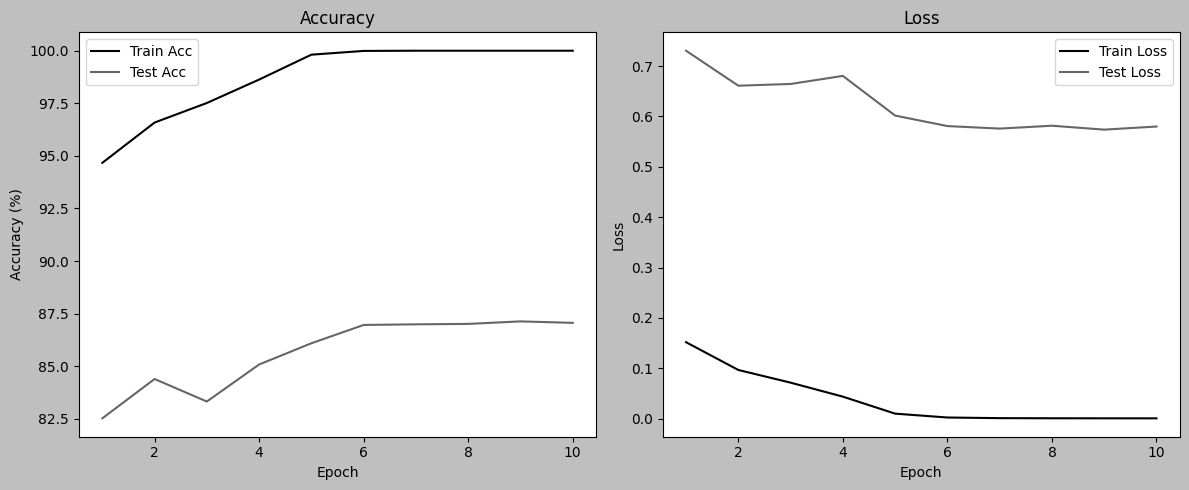

In [32]:
train_accs, test_accs, train_losses, test_losses = [], [], [], []

train(epochs)

acc = test(model)
print(f'quantize Accuracy: {acc:.2f}%')
q8_model = model

plot_acc_loss()

In [33]:
print(f"model size: {size_model} params | {size_model * 8 / 8e6:.2f} MB")

model size: 1188170 params | 1.19 MB


In [35]:
dummy_input = torch.randn(1, 3, 32, 32, requires_grad=False)
dummy_input = dummy_input.to(device)
torch.onnx.export(
            model,                   # مدل برای صدور
            dummy_input,             # ورودی نمونه
            "/kaggle/working/q8_new3.onnx",          # مسیر فایل خروجی
            export_params=True,      # ذخیره وزن‌های آموزش‌دیده
            opset_version=11,        # ورژن استاندارد ONNX (مثلاً 11)
            do_constant_folding=True,# بهینه‌سازی برای حذف محاسبات ثابت
            input_names=['input'],   # نام ورودی
            output_names=['output'], # نام خروجی
            custom_opsets={          # **مهمترین بخش**
                CUSTOM_OP_DOMAIN: CUSTOM_OPSET_VERSION # ثبت دامنه و ورژن اپراتورهای سفارشی
            }
        )

/tmp/ipykernel_133/1785090321.py:158: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.a_bits.item() == 32:
/tmp/ipykernel_133/1785090321.py:160: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  elif self.a_bits.item() == 1:
/tmp/ipykernel_133/1785090321.py:225: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.w_bits.item() == 32:


In [ ]:
torch.onnx.export(
                  model,                       # Your model
                  dummy_input,                 # Sample input
                  "/kaggle/working/base_model_out.onnx",              # Path to save the ONNX file
                  export_params=True,          # Store the trained weights
                  opset_version=11,            # ONNX opset version (or a version compatible with ONNX2C)
                  do_constant_folding=True,    # Execute constant folding optimization
                  input_names = ['input_image'], # Custom name for the input layer
                  output_names = ['predictions'],# Custom name for the output layer
                  dynamic_axes={'input_image' : {0 : 'batch_size'}, # Allow for dynamic batch_size
                                'predictions' : {0 : 'batch_size'}})

In [47]:
convert_to_onnx(q8_model, "q8.onnx")

/tmp/ipykernel_35/2931994109.py:155: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.a_bits.item() == 32:
/tmp/ipykernel_35/2931994109.py:157: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  elif self.a_bits.item() == 1:
/tmp/ipykernel_35/2931994109.py:231: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.w_bits.item() == 32:
/tm

دقت مدل به اندازه مدل اولیه است و کاهش دقت نداشتیم

# 16

In [40]:
model = copy.deepcopy(baseline_model)
model = prepare(model, w_bits=16, a_bits=16).to(device)

epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

In [ ]:
train_accs, test_accs, train_losses, test_losses = [], [], [], []

train(epochs)

acc = test(model)
print(f'quantize Accuracy: {acc:.2f}%')
q16_model = model

plot_acc_loss()

Epoch 1/10 - Train Acc: 100.00%, Test Acc: 87.14%
Epoch 2/10 - Train Acc: 100.00%, Test Acc: 87.13%
Epoch 3/10 - Train Acc: 100.00%, Test Acc: 87.12%
Epoch 4/10 - Train Acc: 100.00%, Test Acc: 87.06%
Epoch 5/10 - Train Acc: 100.00%, Test Acc: 87.26%


In [42]:
dummy_input = torch.randn(1, 3, 32, 32, requires_grad=False)
dummy_input = dummy_input.to(device)
torch.onnx.export(
            model,                   # مدل برای صدور
            dummy_input,             # ورودی نمونه
            "/kaggle/working/q16_new.onnx",          # مسیر فایل خروجی
            export_params=True,      # ذخیره وزن‌های آموزش‌دیده
            opset_version=11,        # ورژن استاندارد ONNX (مثلاً 11)
            do_constant_folding=True,# بهینه‌سازی برای حذف محاسبات ثابت
            input_names=['input'],   # نام ورودی
            output_names=['output'], # نام خروجی
            custom_opsets={          # **مهمترین بخش**
                CUSTOM_OP_DOMAIN: CUSTOM_OPSET_VERSION # ثبت دامنه و ورژن اپراتورهای سفارشی
            }
        )

/tmp/ipykernel_133/1785090321.py:158: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.a_bits.item() == 32:
/tmp/ipykernel_133/1785090321.py:160: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  elif self.a_bits.item() == 1:
/tmp/ipykernel_133/1785090321.py:225: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.w_bits.item() == 32:


## For 6, 4 bit

In [36]:
model = copy.deepcopy(baseline_model)
model = prepare(model, w_bits=6, a_bits=6).to(device)

epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

Epoch 1/10 - Train Acc: 94.16%, Test Acc: 81.89%
Epoch 2/10 - Train Acc: 96.22%, Test Acc: 81.00%
Epoch 3/10 - Train Acc: 97.63%, Test Acc: 81.09%
Epoch 4/10 - Train Acc: 98.91%, Test Acc: 84.90%
Epoch 5/10 - Train Acc: 99.55%, Test Acc: 85.66%
Epoch 6/10 - Train Acc: 99.96%, Test Acc: 86.88%
Epoch 7/10 - Train Acc: 100.00%, Test Acc: 87.13%
Epoch 8/10 - Train Acc: 100.00%, Test Acc: 87.35%
Epoch 9/10 - Train Acc: 100.00%, Test Acc: 87.32%
Epoch 10/10 - Train Acc: 100.00%, Test Acc: 87.44%
quantize Accuracy: 87.44%


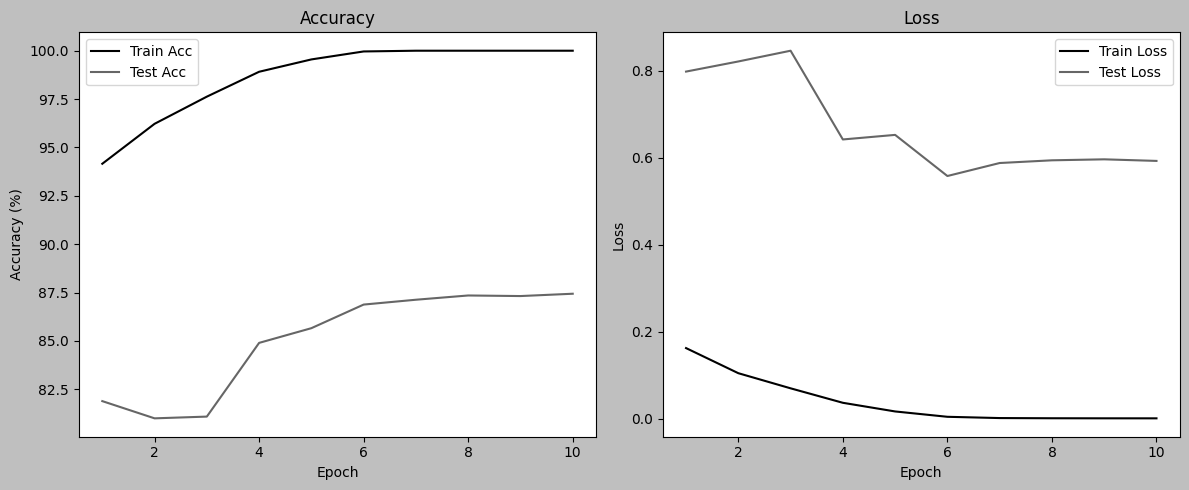

In [37]:
train_accs, test_accs, train_losses, test_losses = [], [], [], []

train(epochs)

acc = test(model)
print(f'quantize Accuracy: {acc:.2f}%')
q6_model = model

plot_acc_loss()

In [38]:
print(f"model size: {size_model} params | {size_model * 6 / 8e6:.2f} MB")

model size: 1188170 params | 0.89 MB


In [39]:
dummy_input = torch.randn(1, 3, 32, 32, requires_grad=False)
dummy_input = dummy_input.to(device)
torch.onnx.export(
            model,                   # مدل برای صدور
            dummy_input,             # ورودی نمونه
            "/kaggle/working/q6_new.onnx",          # مسیر فایل خروجی
            export_params=True,      # ذخیره وزن‌های آموزش‌دیده
            opset_version=11,        # ورژن استاندارد ONNX (مثلاً 11)
            do_constant_folding=True,# بهینه‌سازی برای حذف محاسبات ثابت
            input_names=['input'],   # نام ورودی
            output_names=['output'], # نام خروجی
            custom_opsets={          # **مهمترین بخش**
                CUSTOM_OP_DOMAIN: CUSTOM_OPSET_VERSION # ثبت دامنه و ورژن اپراتورهای سفارشی
            }
        )

/tmp/ipykernel_133/1785090321.py:158: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.a_bits.item() == 32:
/tmp/ipykernel_133/1785090321.py:160: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  elif self.a_bits.item() == 1:
/tmp/ipykernel_133/1785090321.py:225: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.w_bits.item() == 32:


In [49]:
convert_to_onnx(q6_model, "q6.onnx")

/tmp/ipykernel_35/2931994109.py:155: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.a_bits.item() == 32:
/tmp/ipykernel_35/2931994109.py:157: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  elif self.a_bits.item() == 1:
/tmp/ipykernel_35/2931994109.py:231: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.w_bits.item() == 32:
/tm

In [41]:
model = copy.deepcopy(baseline_model)
model = prepare(model, w_bits=4, a_bits=4).to(device)

epochs = 10
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

Epoch 1/10 - Train Acc: 92.26%, Test Acc: 80.51%
Epoch 2/10 - Train Acc: 94.92%, Test Acc: 82.31%
Epoch 3/10 - Train Acc: 96.43%, Test Acc: 80.70%
Epoch 4/10 - Train Acc: 97.90%, Test Acc: 83.70%
Epoch 5/10 - Train Acc: 99.24%, Test Acc: 79.86%
Epoch 6/10 - Train Acc: 99.79%, Test Acc: 86.17%
Epoch 7/10 - Train Acc: 99.98%, Test Acc: 86.49%
Epoch 8/10 - Train Acc: 100.00%, Test Acc: 87.50%
Epoch 9/10 - Train Acc: 100.00%, Test Acc: 87.53%
Epoch 10/10 - Train Acc: 100.00%, Test Acc: 87.61%
quantize Accuracy: 87.61%


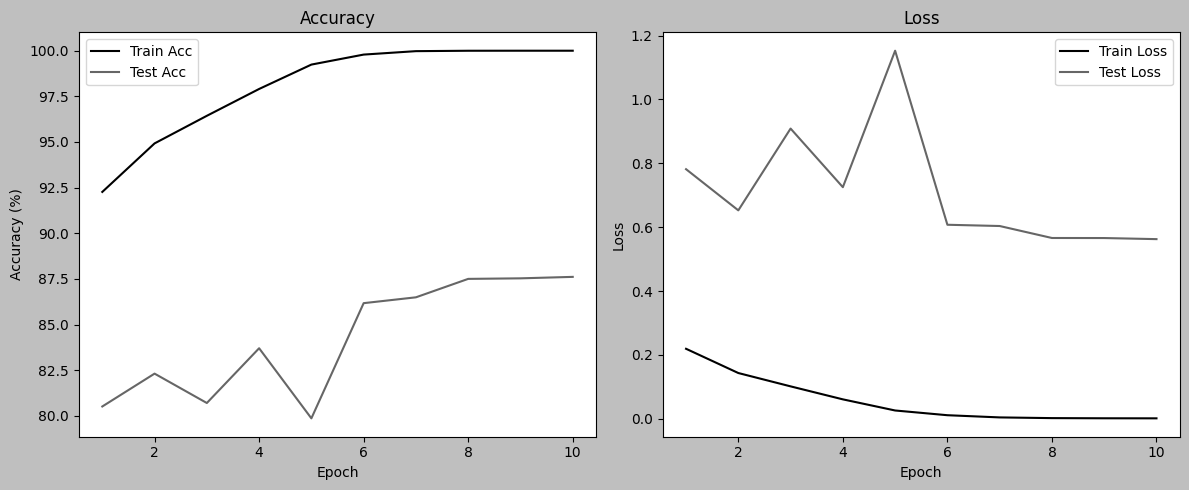

In [42]:
train_accs, test_accs, train_losses, test_losses = [], [], [], []

train(epochs)

acc = test(model)
print(f'quantize Accuracy: {acc:.2f}%')
q4_model = model

plot_acc_loss()

In [43]:
print(f"model size: {size_model} params | {size_model * 4 / 8e6:.2f} MB")

model size: 1188170 params | 0.59 MB


In [50]:
convert_to_onnx(q4_model, "q4.onnx")

/tmp/ipykernel_35/2931994109.py:155: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.a_bits.item() == 32:
/tmp/ipykernel_35/2931994109.py:157: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  elif self.a_bits.item() == 1:
/tmp/ipykernel_35/2931994109.py:231: TracerWarning: Converting a tensor to a Python number might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  if self.w_bits.item() == 32:
/tm

در ۴ بیت ۰.۶ درصد افت دقت و در ۶ بیت ۰.۲۵ درصد افت دقت داشتیم

## Best prune model

In [44]:
# l1_uns_glob_step : 0.8, 0.6, 0.4

for l1 in [0.8, 0.6, 0.4]:
    for q_bit in [8, 6]:
        s_model = size_model * (1-l1)
        print(f"L1-Global Iterative Prune with {l1*100:.0f}% and quantize with {q_bit}bits size: {s_model:.0f} params | {s_model * q_bit / 8e6:.2f} MB")

L1-Global Iterative Prune with 80% and quantize with 8bits size: 237634 params | 0.24 MB
L1-Global Iterative Prune with 80% and quantize with 6bits size: 237634 params | 0.18 MB
L1-Global Iterative Prune with 60% and quantize with 8bits size: 475268 params | 0.48 MB
L1-Global Iterative Prune with 60% and quantize with 6bits size: 475268 params | 0.36 MB
L1-Global Iterative Prune with 40% and quantize with 8bits size: 712902 params | 0.71 MB
L1-Global Iterative Prune with 40% and quantize with 6bits size: 712902 params | 0.53 MB


In [45]:
epochs = 8
# first for l1 % and second for q level
q_l1_uns_glob_step = dict()
for l1 in [0.8, 0.6, 0.4]:
    q_l1_uns_glob_step[l1] = dict()
    for q_bit in [8, 6]:
        model = copy.deepcopy(l1_uns_glob_step[l1])
        model = prepare(model, w_bits=q_bit, a_bits=q_bit).to(device)
        
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        train_accs, test_accs, train_losses, test_losses = [], [], [], []
        
        train(epochs)
        
        acc = test(model)
        print(f'L1-Global Iterative Prune with {l1*100:.0f}% and quantize with {q_bit}bits Accuracy: {acc:.2f}%')
        q_l1_uns_glob_step[l1][q_bit] = copy.deepcopy(model)
        
        plot_acc_loss()

KeyboardInterrupt: 

در ابتدا دیدیم مدل

L1-Global Iterative

از همه بهتر عمل کرده بود
با مقدادیر مختلف آن مدل را کوانتایز کردیم و آموزش دادیم و با توجه به مقادیر به نظر بیشترین فشرده سازی یعنی ۸۰ درصد هرس و ۶ بیت دقت ۸۶.۹ را می دهد که تنها ۰.۷ کاهش دقت دارد ولی حجم آن به ۰.۳۶ مگابایت می رسد.